# Hypothesis 3

Hypothesis: Model perform better on males than on females

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

# sklearn models, evaluation and cross validation
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate

# Plotting settings
# In case the font Cambria is not locally installed in you system, 
# comment out the line below
plt.rcParams['font.serif'] = "Cambria"
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = 10,6

# Set seed for reproducilibity
np.random.seed(0)

# Define data paths that are necessary
DPATH = "../data/"
RPATH = "../results/"
CNPATH = "../data/control/"
CDPATH = "../data/condition/"

In [2]:
# Custom scoring function to approach the hypothesis
def madrs_scores(model, X, y):
    madrs1 = X[:, -2]
    madrs2 = X[:, -2]
    y_pred = model.predict(X)
    
    avg_madrs = (madrs1+madrs2)//2
    # Identifying mild and severe depression
    mild = np.where(avg_madrs < 20)[0]
    severe = np.where(~(avg_madrs < 20))[0]
    
    mild_acc = accuracy_score(y[mild], y_pred[mild])
    severe_acc = accuracy_score(y[severe], y_pred[severe])
    
    mild_f1 = f1_score(y[mild], y_pred[mild])
    severe_f1 = f1_score(y[severe], y_pred[severe])
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    return {"mild_acc": mild_acc, "mild_f1": mild_f1, \
            "severe_acc": severe_acc, "severe_f1": severe_f1, \
            "accuracy": accuracy, "f1": f1}

In [3]:
# Load dataset
X = np.load(DPATH+"final_X_madrs.npy")
y = np.load(DPATH+"final_y.npy")
y = y.reshape(-1, )

pca = PCA()
X_transformed = pca.fit_transform(X[:, :-2])
X_transformed = np.hstack([X_transformed, X[:, -2:]])

print(X.shape, y.shape, X_transformed.shape)

(773, 1442) (773,) (773, 775)


In [4]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.20, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(618, 1442)
(124, 1442)
(31, 1442)


In [5]:
lr = LogisticRegression(random_state=42, max_iter=int(1e3))
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_val_pred = lr.predict(X_val)
y_test_pred = lr.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("train accuracy:", train_accuracy)
print("val accuracy:", val_accuracy)
print("test accuracy:", test_accuracy)

train accuracy: 1.0
val accuracy: 0.5483870967741935
test accuracy: 0.3548387096774194


In [6]:
# Cross Validaiton
cv = 20
scores = cross_validate(lr, X, y, cv=cv, scoring=madrs_scores)
df_lr = pd.DataFrame(scores, index=range(cv))
df_lr.to_csv(RPATH+"H4_lr_cv.csv")
display(df_lr.mean())

fit_time           0.227965
score_time         0.003072
test_mild_acc      0.573788
test_mild_f1       0.241556
test_severe_acc    0.479380
test_severe_f1     0.635959
test_accuracy      0.549730
test_f1            0.460966
dtype: float64

---
Clearly logistic regression is doing a poor job here
---

In [7]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("train accuracy:", train_accuracy)
print("val accuracy:", val_accuracy)
print("test accuracy:", test_accuracy)

train accuracy: 1.0
val accuracy: 0.9032258064516129
test accuracy: 0.8709677419354839


In [8]:
# Cross Validaiton
cv = 20
scores = cross_validate(rf, X, y, cv=cv, scoring=madrs_scores)
df_rf = pd.DataFrame(scores, index=range(cv))
df_rf.to_csv(RPATH+"H4_rf_cv.csv")
display(df_rf.mean())

fit_time           0.667859
score_time         0.006607
test_mild_acc      0.947867
test_mild_f1       0.845885
test_severe_acc    0.933155
test_severe_f1     0.963565
test_accuracy      0.943117
test_f1            0.928020
dtype: float64

---
Well, random forest even without finetuning is performing well with default parameters
---

To do:
- [ ] Same as above;
- [ ] Grid Search for both

## Trying Dimensionality Reduction techniques

In [9]:
pca = PCA()
pca.fit(X_train[:, :-2])
X_train_transformed = pca.transform(X_train[:, :-2])
X_train_transformed = np.hstack([X_train_transformed, X_train[:, -2:]])
X_val_transformed = pca.transform(X_val[:, :-2])
X_val_transformed = np.hstack([X_val_transformed, X_val[:, -2:]])
X_test_transformed = pca.transform(X_test[:, :-2])
X_test_transformed = np.hstack([X_test_transformed, X_test[:, -2:]])

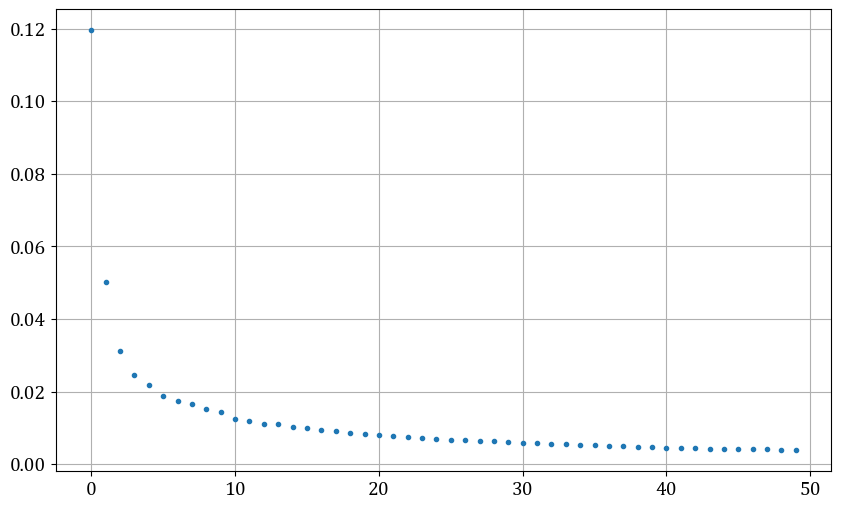

In [10]:
plt.figure()
plt.plot(pca.explained_variance_ratio_[:50], '.')
plt.show()

In [11]:
lr_pca = LogisticRegression(random_state=42, max_iter=int(1e3))
lr_pca.fit(X_train_transformed, y_train)
y_train_pred = lr_pca.predict(X_train_transformed)
y_val_pred = lr_pca.predict(X_val_transformed)
y_test_pred = lr_pca.predict(X_test_transformed)
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("train accuracy:", train_accuracy)
print("val accuracy:", val_accuracy)
print("test accuracy:", test_accuracy)

train accuracy: 1.0
val accuracy: 0.5483870967741935
test accuracy: 0.5161290322580645


In [12]:
# Cross Validaiton
cv = 20
scores = cross_validate(lr_pca, X_transformed, y, cv=cv, scoring=madrs_scores)
df_lr_pca = pd.DataFrame(scores, index=range(cv))
df_lr_pca.to_csv(RPATH+"H4_lr_pca_cv.csv")
display(df_lr_pca.mean())

fit_time           0.129946
score_time         0.003202
test_mild_acc      0.432109
test_mild_f1       0.359831
test_severe_acc    0.813784
test_severe_f1     0.893000
test_accuracy      0.541903
test_f1            0.602859
dtype: float64

In [13]:
rf_pca = RandomForestClassifier()
rf_pca.fit(X_train_transformed, y_train)
y_train_pred = rf_pca.predict(X_train_transformed)
y_val_pred = rf_pca.predict(X_val_transformed)
y_test_pred = rf_pca.predict(X_test_transformed)
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("train accuracy:", train_accuracy)
print("val accuracy:", val_accuracy)
print("test accuracy:", test_accuracy)

train accuracy: 1.0
val accuracy: 0.9838709677419355
test accuracy: 0.9354838709677419


In [14]:
# Cross Validaiton
cv = 20
scores = cross_validate(rf_pca, X_transformed, y, cv=cv, scoring=madrs_scores)
df_rf_pca = pd.DataFrame(scores, index=range(cv))
df_rf_pca.to_csv(RPATH+"H4_rf_pca_cv.csv")
display(df_rf_pca.mean())

fit_time           0.840939
score_time         0.006684
test_mild_acc      0.966284
test_mild_f1       0.885986
test_severe_acc    1.000000
test_severe_f1     1.000000
test_accuracy      0.975540
test_f1            0.968886
dtype: float64

PCA didn't help much in case of RF; In case of Logistic Regression, it vastly improved the F1 score.